In [1]:
import os

import pandas as pd

from common.libs.data_analysis.SeriesDescriber import *
from common.libs.data_analysis.SeriesDescriberWRTTarget import *
from common.libs.DataDisplayer import *
import tensorflow as tf

C:\Users\zuolo\anaconda3\envs\tensor_data_science\Lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


### Data Initialization

In [2]:
TRAIN_FILE = os.path.join(os.getcwd(),
                          "inputs",
                          "model_ready",
                          "train",
                          "0.csv")

TEST_FILE = os.path.join(os.getcwd(),
                         "inputs",
                         "model_ready",
                         "test",
                         "0.csv")

In [3]:
train_df = pd.read_csv(TRAIN_FILE)
test_df = pd.read_csv(TEST_FILE)

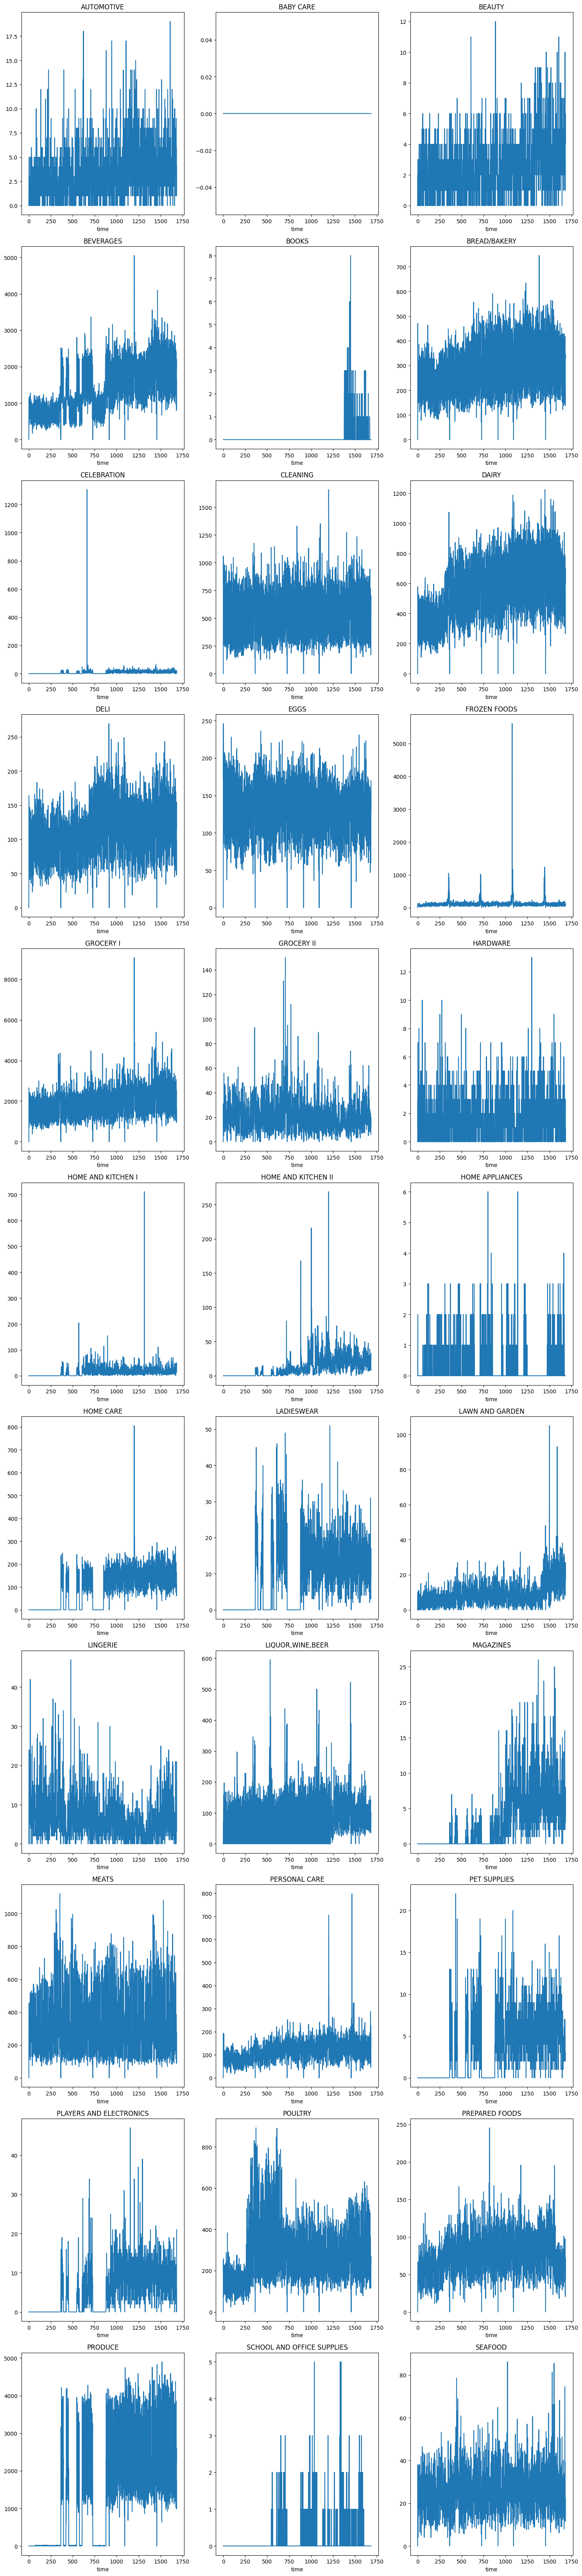

In [25]:
uppercase_cols = [col for col in train_df.columns if col.isupper()]
display_df = train_df[uppercase_cols]

import matplotlib.pyplot as plt

# Create subplots
n_cols = len(uppercase_cols)
fig, axes = plt.subplots(nrows=(n_cols + 2) // 3, ncols=3, figsize=(15, n_cols * 2))
axes = axes.flatten()

for idx, col in enumerate(uppercase_cols):
    display_df[col].plot(ax=axes[idx])
    axes[idx].set_title(col)
    axes[idx].set_xlabel('time')

# Hide empty subplots
for idx in range(len(uppercase_cols), len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.show()

In [4]:
xs = train_df.drop(columns=["date",
                            "store_nbr",
                            "city",
                            "state",
                            "cluster",
                            *[f"type_{chr(i)}" for i in range(ord('A'), ord('E') + 1)]],
                   axis=1)

print(xs.shape)
xs.head()

(1684, 39)


,AUTOMOTIVE,BABY CARE,BEAUTY,BEVERAGES,BOOKS,BREAD/BAKERY,CELEBRATION,CLEANING,DAIRY,DELI,...,PREPARED FOODS,PRODUCE,SCHOOL AND OFFICE SUPPLIES,SEAFOOD,dcoilwtico,vacation holiday,vacation additional,vacation bridge,vacation work day,vacation event
0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.000,...,0.0,0.0,0.0,0.000000,93.076667,1,0,0,0,0
1,2.0,0.0,2.0,1091.0,0.0,470.652,0.0,1060.0,579.0,164.069,...,47.0,0.0,0.0,38.029000,93.140000,0,0,0,0,0
2,3.0,0.0,0.0,919.0,0.0,310.655,0.0,836.0,453.0,151.582,...,63.0,0.0,0.0,17.366001,92.970000,0,0,0,0,0
3,3.0,0.0,3.0,953.0,0.0,198.366,0.0,827.0,460.0,131.411,...,67.0,0.0,0.0,29.907001,93.120000,0,0,0,0,0
4,5.0,0.0,3.0,1160.0,0.0,301.057,0.0,811.0,464.0,118.613,...,66.0,0.0,0.0,24.842000,93.113810,0,0,0,1,0


### Model creation

In [5]:
from common.libs.data_analysis.SeriesDescriberWRTTarget import *
from common.classes.DataGenerators import SeqDataGeneratorList
from common.classes.CustomCallbacks import BatchMetricsCallback


In [7]:
D = 1  # Dimensionality of the data. Since your data is 1-D this would be 1
NUM_UNROLLINGS = 50  # Number of time steps you look into the future.
BATCH_SIZE = 200  # Number of samples in a batch
NUM_NODES = [200, 200, 150]  # Number of hidden nodes in each layer of the deep LSTM stack we're using
N_LAYERS = len(NUM_NODES)  # number of layers
DROPOUT = 0.2  # Dropout amount

tf.compat.v1.reset_default_graph()  # This is important in case you run this multiple times

xs_np = xs.to_numpy()

In [8]:
# Input data
dg = SeqDataGeneratorList(xs, BATCH_SIZE, NUM_UNROLLINGS)
train_inputs, train_outputs = dg.unroll_batches()

print(train_inputs.shape)
print(train_outputs.shape)

(200, 50, 39)
(200, 1, 39)


In [9]:
layers = [tf.keras.layers.Input(shape=(train_inputs.shape[1], train_inputs.shape[2])),
          *[tf.keras.layers.LSTM(
                  NUM_NODES[layer],
                  return_sequences=(layer < N_LAYERS - 1)
          ) for layer in range(N_LAYERS)],
          tf.keras.layers.Dense(train_outputs.shape[2])]

model = tf.keras.Sequential(layers)

model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss='mse',
        metrics=[
            'mae'
        ]
)
# Cant use F1 cuz not categorical data


In [10]:
epochs = 100
dataset = tf.data.Dataset.from_generator(
        dg.as_generator(),
        output_signature=(
            tf.TensorSpec(shape=train_inputs.shape, dtype=tf.float32),
            tf.TensorSpec(shape=train_outputs.shape, dtype=tf.float32)
        )
)
# Train using model.fit with dataset
callback = BatchMetricsCallback()
history = model.fit(
        dataset,
        epochs=epochs,
        steps_per_epoch=1,
        callbacks=[callback],
        verbose=2
)


Epoch 1/100
1/1 - 2s - 2s/step - loss: 344917.9062 - mae: 214.1124
Epoch 2/100
1/1 - 0s - 340ms/step - loss: 353896.6250 - mae: 212.4062
Epoch 3/100
1/1 - 0s - 317ms/step - loss: 393325.9062 - mae: 228.7673
Epoch 4/100
1/1 - 0s - 290ms/step - loss: 358780.5312 - mae: 219.6571
Epoch 5/100
1/1 - 0s - 310ms/step - loss: 368524.2812 - mae: 221.4904
Epoch 6/100
1/1 - 0s - 356ms/step - loss: 365861.3750 - mae: 222.4013
Epoch 7/100
1/1 - 0s - 340ms/step - loss: 356353.3750 - mae: 218.4893
Epoch 8/100
1/1 - 0s - 340ms/step - loss: 371476.3750 - mae: 221.4125
Epoch 9/100
1/1 - 0s - 389ms/step - loss: 399938.8438 - mae: 227.3371
Epoch 10/100
1/1 - 0s - 294ms/step - loss: 331586.4062 - mae: 207.8326
Epoch 11/100
1/1 - 0s - 294ms/step - loss: 363011.0312 - mae: 216.9806
Epoch 12/100
1/1 - 0s - 374ms/step - loss: 373002.3125 - mae: 225.7241
Epoch 13/100
1/1 - 0s - 311ms/step - loss: 320251.9688 - mae: 202.6226
Epoch 14/100
1/1 - 0s - 337ms/step - loss: 371996.4688 - mae: 227.0947
Epoch 15/100
1/1 -

KeyboardInterrupt: 

In [ ]:
plt.plot(callback.batch_losses, label='mse')
plt.plot(callback.batch_maes, label='mae')
plt.legend()
plt.show()